# Reduced classifications subset

This notebook displays plots for analysis of reduced classifications. This will allow us to check whether there are any oddities or inconsistencies in the reduced data.

In [1]:
import collections
import json
from pathlib import Path
import re

from astropy.coordinates import SkyCoord
import astropy.io.ascii
import astropy.wcs
import matplotlib.pyplot as plt
import numpy as np
import requests
from tqdm.auto import tqdm

import rgz.classifications
import rgz.subjects

In [2]:
RAW_CLASSIFICATIONS_PATH = Path('../data/radio_classifications_subset.json')
CLASSIFICATIONS_PATH = Path("../data/radio_classifications_subset_processed.json")
SUBJECTS_PATH = Path("../data/radio_subjects_subset_processed.json")
RGZ_DR1_HOST_PATH = Path("../data/DR1_FIRST_host_properties.csv")

In [3]:
dr1_hosts = astropy.io.ascii.read(RGZ_DR1_HOST_PATH, format="csv")

In [4]:
with open(CLASSIFICATIONS_PATH) as f:
    classifications = [rgz.classifications.deserialise_classification(c)
                       for c in json.load(f)]

In [5]:
with open(SUBJECTS_PATH) as f:
    subjects = [rgz.subjects.deserialise_subject(s)
                for s in json.load(f)]

In [6]:
classifications[0]

Classification(cid='52b20d152b60f17f5f002673', zid='ARG0002w6r', matches=[('10 07 30.57933226 +12 02 18.47351685', {'FIRST_J100730.6+120218'})], username='gio1202', notes=[])

In [7]:
len(classifications)

34269

In [8]:
raw_classifications = []
with open(RAW_CLASSIFICATIONS_PATH) as f:
    for row in f:
        raw_classifications.append(json.loads(row))

In [9]:
len(raw_classifications)

34269

## Classifications per subject (and the ensuing mysteries therein)

How many classifications are there per subject?

In [10]:
subject_to_count = collections.Counter()
for c in classifications:
    subject_to_count[c.zid] += 1

In [11]:
subject_to_count.most_common(5)

[('ARG0002mfx', 3184),
 ('ARG0002wel', 146),
 ('ARG0002xpu', 80),
 ('ARG0002txy', 35),
 ('ARG0002goj', 34)]

The most common subject has been classified >3000 times. This is because we accidentally picked up a gold standard example in the subset!

Text(0, 0.5, 'Subjects')

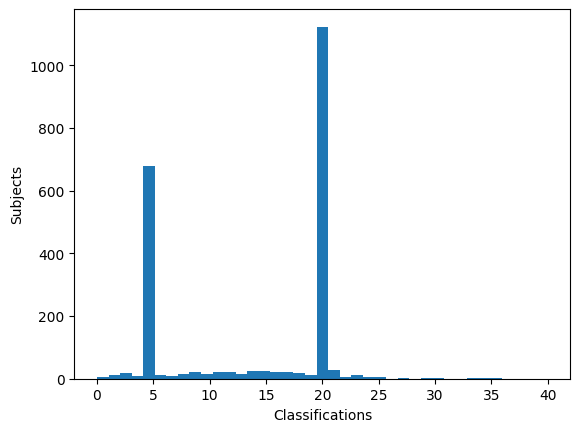

In [12]:
plt.hist(subject_to_count.values(), bins=np.linspace(0, 40, 40))
plt.xlabel('Classifications')
plt.ylabel('Subjects')

The threshold is 5 or 20 for RGZ. Some are below 5:

In [13]:
sum(1 for v in subject_to_count.values() if v < 5) / len(subject_to_count)

0.01979742173112339

About 2%.

## Gold standard

In [48]:
gs = subjects[0].zid

In [49]:
gs_cs = [c for c in classifications if c.zid == gs]

In [50]:
xs = []
ys = []
n_no_source = 0
n_multisource = 0
for c in gs_cs:
    if not c.matches:
        continue
    if len(c.matches) > 1:
        n_multisource += 1
    source = c.matches[0][0]
    if source == 'NOSOURCE':
        n_no_source += 1
        continue
    l = SkyCoord(source, unit='hourangle,deg')
    xs.append(l.ra.deg)
    ys.append(l.dec.deg)

In [51]:
n_no_source / len(gs_cs)

0.0

In [52]:
n_multisource / len(gs_cs)

0.55

In [53]:
gs_subject = subjects[1]

In [54]:
cutout = astropy.io.fits.open(f'../data/cache/{gs_subject.id}.fits')

In [55]:
wcs = astropy.wcs.WCS(header=cutout[0].header)

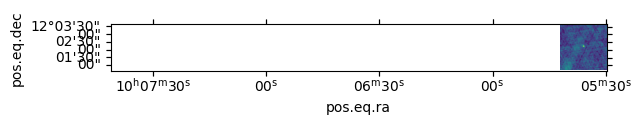

In [56]:
fig = plt.figure()
ax = fig.add_subplot(projection=wcs, slices=('x', 'y', 0, 0))
ax.imshow(cutout[0].data)
ax.scatter(xs, ys, s=1, c='w', transform=ax.get_transform('fk5'), alpha=1)

In [28]:
c

Classification(cid='53a85f07037b3051b200018c', zid='ARG0002wel', matches=[('10 08 01.72030496 +11 58 07.58526946', {'FIRST_J100801.7+115805'}), ('NOSOURCE', {'FIRST_J100802.8+115742'}), ('NOSOURCE', {'FIRST_J100800.2+115831'}), ('NOSOURCE', {'FIRST_J100800.6+115907'})], username='dude1818', notes=[])

In [29]:
xs = []
ys = []
n_no_source = 0
for match in c.matches:
    source = match[1]
    m = r.search(next(iter(match[1])))
    print(source)
    l = SkyCoord(ra='{} {} {}'.format(*m.groups()[:3]), dec='{} {} {}'.format(*m.groups()[3:]), unit='hourangle,deg')
    xs.append(l.ra.deg)
    ys.append(l.dec.deg)

{'FIRST_J100801.7+115805'}
{'FIRST_J100802.8+115742'}
{'FIRST_J100800.2+115831'}
{'FIRST_J100800.6+115907'}


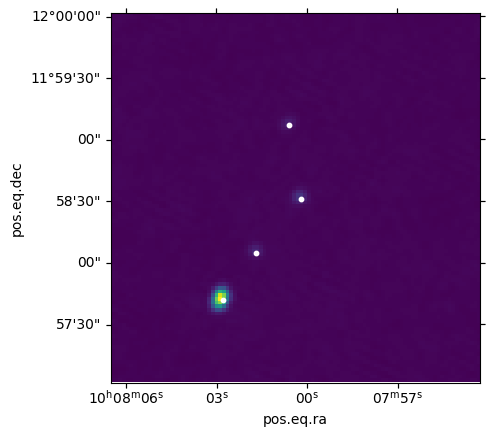

In [31]:
fig = plt.figure()
ax = fig.add_subplot(projection=wcs, slices=('x', 'y', 0, 0))
ax.imshow(cutout[0].data)
ax.scatter(xs, ys, s=10, c='w', transform=ax.get_transform('fk5'), alpha=1)

In [57]:
c

Classification(cid='5310e15541ecea164a0043eb', zid='ARG0002w6r', matches=[], username='NO_USER_NAME', notes=[])